# Spherical harmonics and the angular power spectrum of the CMB

## Introduction

We use the `scipy` library to plot spherical harmonics in 3D. This notebook largely follows the example from the `scipy` docs, with some small changes to allow for a single $\ell, m$ pair to be plotted, or a grid of many pairs. 

Why are we interested in this? Spherical harmonics appear often in cosmology, since we are dealing with fields on the (spherical) sky. 

Consider the field $f(\theta, \phi)$, a function of the spherical polar coordinates $\theta, \phi$. We can perform a multipole expansion of the field,
\begin{equation}
f(\theta, \phi) = \sum a_{\ell m} Y_{\ell m}(\theta, \phi),
\end{equation}
where $Y_{\ell m}(\theta, \phi)$ are the spherical harmonics which form an orthonormal set of functions over the sphere.

The spherical harmonics can in turn be defined using the Legendre polynomials $P_{\ell m}$,
\begin{equation}
Y_{\ell m}(\theta, \phi) = (-1)^m \sqrt{\frac{2 \ell + 1}{4 \pi} \frac{(\ell -m)!}{(\ell + m)!}} P_{\ell m} (\cos \theta) e^{i m \phi}.
\end{equation}

The multipole coefficients $a_{\ell m}$ are defined via
\begin{equation}
a_{\ell m} = \int Y_{\ell m}^*(\theta, \phi) f(\theta, \phi) d\Omega,
\end{equation}
where $d\Omega = \sin \theta d\theta \phi$ is the integration measure for integrating over the surface of a sphere.

Let us take the cosmic microwave background temperature field as our field $f(\theta, \phi)$. Anisotropies in this field are (primarily) due to primordial perturbations, which are thought to be Gaussian. This means that the multipole coefficients $a_{\ell m}$ are also Gaussian random variables.

The expectation value is zero,
\begin{equation}
\langle a_{\ell m} \rangle = 0,
\end{equation}
since in the case of the CMB, we expect positive and negative deviations from the mean temperature to average to zero. The variance, $\langle |a_{\ell m}|^2 \rangle$, is thus the quantity of interest, giving the typical size of the $a_{\ell m}$.

**A key point**: the $\ell$ indices are responsible for the angular size of the anisotropies; the $m$ indices are responsible for the pattern of the anisotropies (this can be seen in the visualisation below). This means that the expectation values mentioned above are not dependent on $m$. This leads us to define
\begin{equation}
C_{\ell} \equiv \langle |a_{\ell m}|^2 \rangle =  \frac{1}{2\ell + 1} \sum_{m} \langle |a_{\ell m}|^2 \rangle,
\end{equation}
where $C_{\ell}$ is called the **angular power spectrum**.

In the case of the CMB, we can further relate this to the variance of the temperature field,
\begin{equation}
\left\langle \left( \frac{\delta T(\theta, \phi)}{T}\right)^2 \right\rangle = \sum_{\ell} \frac{2\ell + 1}{4\pi} C_{\ell}.
\end{equation}

Let us now visualise some Legendre polynomials, spherical harmonics and the CMB.

## Set up

In [1]:
# import numpy for arrays
import numpy as np

# import the spherical harmonics
from scipy.special import sph_harm

# import camb and healpy to simulate a real CMB sky
import camb
import healpy as hp

# import tools from matplotlib for plotting
from matplotlib import rc, rcParams, gridspec, colormaps, pyplot as plt

# import cmasher for nice colourmaps and cmap utilities
import cmasher as cmr

# import warnings to suppress irrelevant jupyter nb warnings
import warnings
warnings.filterwarnings('ignore')

# use serif fonts
rc('text', usetex=True)
rc('font', family='serif')
rcParams.update({'font.size': 24})

# choose any matplotlib or cmasher colourmap
# matplotlib maps can be accessed via e.g. cm = colormaps['twilight']
cm = cmr.infinity 

# where figures will be saved
path = r'/home/natalie/Documents/Projects/los_effects/six_times_two_point/figures/sphar/'

## Plot a few Legendre polynomials

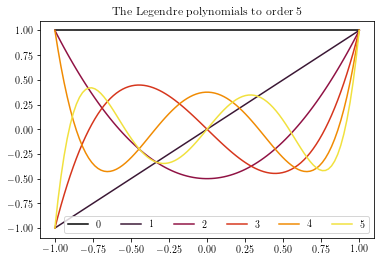

In [2]:
# choose what order to go to (starting at zero so select one higher than the highest you want to visualise)
orders = range(6)

# get some nice colours from a cmasher cmap
colors = cmr.take_cmap_colors(cmr.ember, len(orders), cmap_range=(0.0, 1.0), return_fmt='hex')

# get the polynomials and plot them
for i in orders:
    x, y = np.polynomial.legendre.Legendre.basis(i, [-1, 1]).linspace(100)
    plt.plot(x, y, label=i, color = colors[i])
plt.legend(ncol = len(orders))
plt.title('The Legendre polynomials to order {}'.format(len(orders)-1))
plt.savefig(path + 'legendre_polynomials_order_{}.pdf'.format(len(orders)-1))
plt.show()

## Define plot function for spherical harmonics

In [3]:
def plot_sphar(l, m, cmap, grid, ax):
    '''
    function to compute and plot spherical harmonics
    l: first index (integer)
    m: second index (integer)
    cmap: colour map (matplotlib or cmasher cmap object)
    grid: if True, plots grid of many ell, m pairs. if False, plots a single pair
    ax: axes object to draw on (should be None in the case of grid=False)
    '''
    
    # angles for the spherical harmonics
    theta = np.linspace(0, np.pi, 100)
    phi   = np.linspace(0, 2*np.pi, 100)
    
    # make a grid of the angles
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # Cartesian coordinates from angles
    x = np.sin(theta_grid) * np.cos(phi_grid)
    y = np.sin(theta_grid) * np.sin(phi_grid)
    z = np.cos(theta_grid)
    
    # compute the spherical harmonics
    # note that the scipy sph_harm function takes the arguments in an unintuitive order
    ylm = sph_harm(m, l, theta_grid, phi_grid).real
    
    # normalise the colourmap
    fmax, fmin = ylm.max(), ylm.min()
    fcolors = (ylm - fmin)/(fmax - fmin)
    
    # check the grid settings and set up fig, ax if no grid passed
    if grid == True:
        pass
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev = 0, azim = 90)
        fig.set_tight_layout(True)
    
    if l == m == 0:
        # choose a solid colour from the cmap for the monopole
        fc = cmr.take_cmap_colors(cmap, 1, cmap_range=(0.9, 1.0), return_fmt='hex')
        # plot the monopole
        ax.plot_surface(x, y, z, color=fc[0], rasterized=True)
    else:
        # plot higher order moments; for faster plotting you can increase the strides (default is 10)
        # more info on kwargs: https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html#surface-plots
        ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cmap(fcolors), rasterized=True)
    
    # turn off all the axis labels etc
    ax.set_axis_off()
    
    # title the axis
    ax.set_title('$Y_{{{}{}}}$'.format(l,m))
    
    return 

## Make plots

We can plot a single pair of $(\ell,m)$ by calling the function in this way:

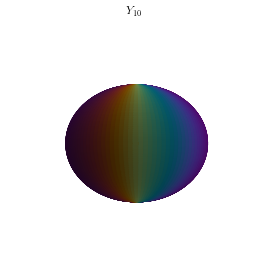

In [4]:
plot_sphar(l=1, m=0, cmap=cm, grid=False, ax=None)

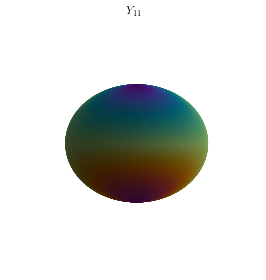

In [5]:
plot_sphar(l=1, m=1, cmap=cm, grid=False, ax=None)

Notice how these dipoles are both the same: the anisotropy has the same angular scale in both. The change in $m$ only changes the *orientation* of the dipole with respect to the observer. This is why the angular power spectrum, coming from the variance of the multipole coefficient, only depends on $\ell$ and not $m$.

Alternatively we can plot many pairs up to a given $\ell_{\mathrm max}$ by passing a GridSpec object to the plotter. In this case we have to initialise the figure and axes outside the function and pass the ax object to it.

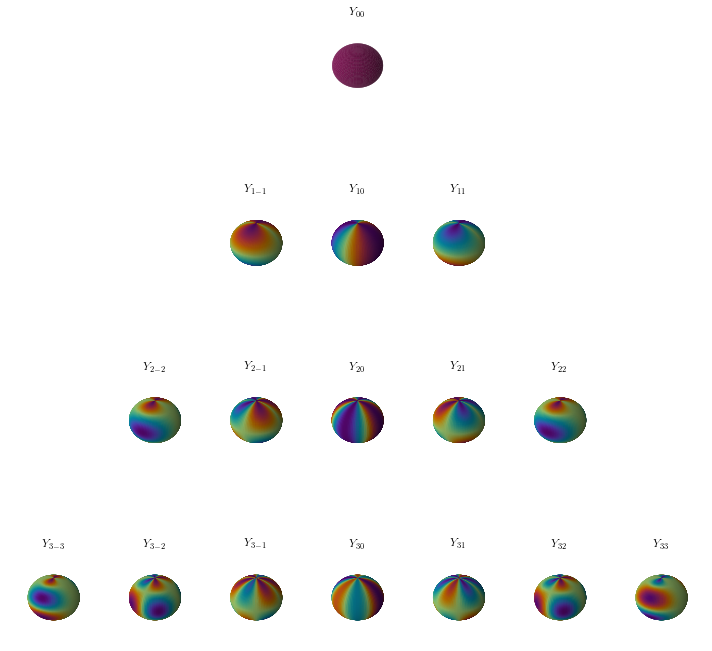

In [6]:
# choose an l-max
ell_max = 3

fig = plt.figure(figsize=(10, 10))

# set up the grid of subplots
grid = gridspec.GridSpec(ncols=2*ell_max+1, nrows=ell_max+1, figure=fig)

# iterate over the l and m
for ell in range(ell_max+1):
    for emm in range(-ell, ell+1): 
        ax = fig.add_subplot(grid[ell, emm+ell_max], projection='3d')
        plot_sphar(l=ell, m=emm, cmap=cm, grid=True, ax=ax)

grid.tight_layout(fig)

# note that the figures are rasterised to make the file smaller; the tradeoff is pixellation when you zoom
plt.savefig(path + 'sphar_grid.pdf') 

## Use CAMB and `healpy` to simulate a real CMB sky

We can now see how the temperature anisotropy map of the CMB observed by Planck is just spherical harmonics stacked on top of each other, going up to a high $\ell$. We can visualise this using CAMB (https://camb.readthedocs.io/en/latest/CAMBdemo.html) and `healpy` (https://healpy.readthedocs.io/en/latest/tutorial.html).

In [7]:
# set up the CAMB parameter object
pars = camb.CAMBparams()

# set some standard LCDM parameters
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)

# get the results
results = camb.get_results(pars)

# get all the power spectra
power_spectra =results.get_cmb_power_spectra(pars, CMB_unit='muK')

# use just the unlensed TT Cl for now
Cls = power_spectra['unlensed_scalar']

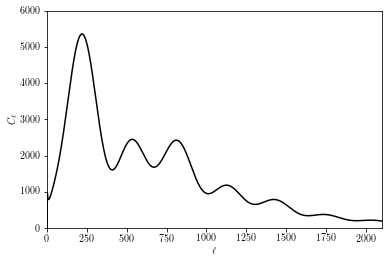

In [8]:
# plot the unlensed TT Cl
ls = np.arange(Cls.shape[0])

plt.plot(ls, Cls[:,0], color='k')
plt.xlim(0, 2100)
plt.ylim(0, 6000)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\rm \ell}$')

plt.show()

One day I will try to plot the full spherical harmonics from my CAMB-produced $C_{\ell}$s myself (as done here: http://find.spa.umn.edu/~pryke/logbook/20000922/) but for now let's be lazy and get `healpy` to do it for us:

In [9]:
# set the resolution
nside = 2**6 # Planck used nside=2048 i.e. 2**11 but this is veeery slow...

# make the CMB map from our theoretical Cls
cmb_map = hp.sphtfunc.synfast(Cls[:,0], nside)

# smooth the map
cmb_map_smoothed = hp.smoothing(cmb_map, fwhm=np.radians(1.))

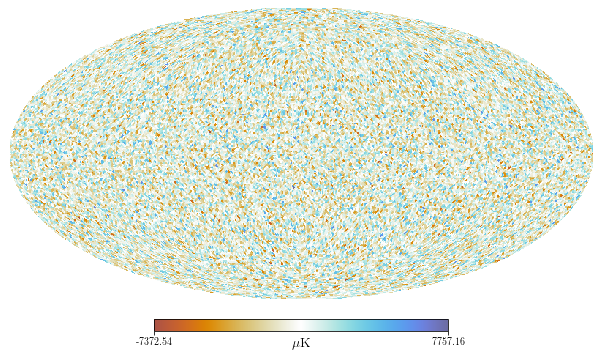

In [10]:
# plot the beautiful CMB sky in a Mollweide projection
hp.mollview(cmb_map_smoothed, cmap=cmr.prinsenvlag, title=None, unit='$\mu$K')
plt.savefig(path + 'cmb_map.pdf')

We can also compute the $C_{\ell}$s for just the first few multipoles, to see what the map looks like.

In [11]:
small_ell_max = 4

pars.set_for_lmax(small_ell_max)

power_spectra_low_ell = results.get_cmb_power_spectra(pars, CMB_unit='muK')

Cls_low_ell = power_spectra_low_ell['unlensed_scalar']

In [12]:
cmb_map_low_ell = hp.sphtfunc.synfast(Cls_low_ell[:,0], nside)

cmb_map_smoothed_low_ell = hp.smoothing(cmb_map_low_ell, fwhm=np.radians(1.))

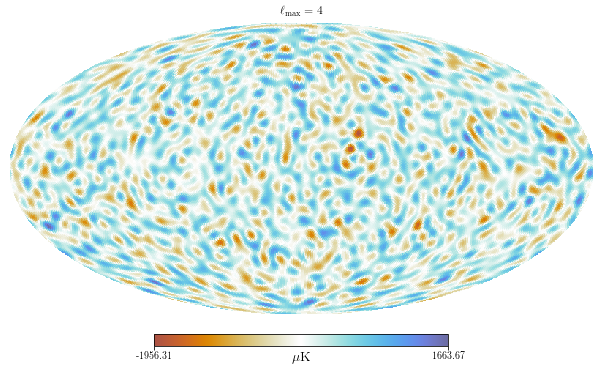

In [13]:
hp.mollview(cmb_map_smoothed_low_ell, cmap=cmr.prinsenvlag, 
            title='$\ell_{{\\rm max}}={}$'.format(small_ell_max), unit='$\mu$K')

plt.savefig(path + 'cmb_map_small_ell_max.pdf')

**To be checked**: is the colourbar scale on these plots correct?